# MYO AI: MYOCARDIUM INTELLIGENCE SYSTEM
## A Multi-Layer Cardiac Risk Prediction & Explainability Platform

---

### Project Overview

Myo AI is a modular, end-to-end cardiovascular disease (CVD) prediction system built around **3 architectural layers** and **11 specialized engines**. It ingests heterogeneous clinical & physiological data, trains 5 fully independent ML/DL models in a fair "tournament", and delivers interactive explainability & risk-projection dashboards.

---

### Architecture Summary

| Layer | Codename | Module | Purpose |
|:---:|---|---|---|
| **1 — Foundation** | Synapse | `SynapseIngestionEngine` | Downloads & harmonizes 4 disparate clinical CSV datasets |
| | Pulse | `run_pulse_harmonization()` | Chunk-processes ~600 MB ECG time-series → statistical features |
| | Catalyst | `CatalystFeatureSynthesizer` | Merges modalities, engineers BMI / Pulse-Pressure, clips outliers |
| **2 — Tournament** | Aegis Protocol | Random Forest Pipeline | Robust tree-ensemble baseline |
| | Myo-Core Engine | HistGradientBoosting Pipeline | Optimized gradient-boosted champion |
| | Sentinel Node | Naive Bayes Pipeline | Probabilistic safety baseline |
| | Vanguard System | Logistic Regression Pipeline | Linear interpretability baseline |
| | Pulse-Sync | 1D-CNN (TensorFlow/Keras) | Deep Learning for complex non-linear patterns |
| **3 — Intelligence** | Zenith Map | PCA + KMeans | Unsupervised patient risk-group clustering |
| | Oracle Layer | SHAP + Permutation Importance | Explainable AI — global & local feature impact |
| | Myo-Sim Bio-Deck | ipywidgets + Chronos Engine | Interactive digital-twin risk simulator with 20-year projection |

---

### Design Principles

| Principle | Implementation |
|---|---|
| **Strict Model Independence** | Each of the 5 models has its own isolated KDD pipeline: Feature Selection → Train/Test Split → Imputation → Scaling → Training → Evaluation. No model shares preprocessed data or fitted transformers with another. |
| **Fair Tournament** | All models use the same `MASTER_DATA` source and identical split parameters (`test_size=0.2, random_state=42, stratify=y`) so performance is directly comparable. |
| **One Graph Per Cell** | Every visualization cell contains exactly one chart type for clarity and reproducibility. |
| **Colab-Ready** | A dedicated setup cell installs all dependencies; no local environment configuration needed. |
| **Ethical Sensor Handling** | A `sensor_signal_available` flag marks ECG data presence/absence — missing sensors are handled transparently, not silently imputed. |

---

### KDD Pipeline (per model)

```
Raw Data → Synapse (Ingest) → Pulse (ECG Features) → Catalyst (Merge & Engineer)
         → MASTER_DATA
         → [Per-Model Independent Pipeline]
            Feature Selection → Stratified Split → Imputation → Scaling → Model Training → Evaluation
```

---

### Technology Stack

| Component | Technology |
|---|---|
| Data Engineering | Pandas, NumPy, SciPy, gdown |
| Machine Learning | Scikit-learn (Pipeline, RandomForest, HGBC, NaiveBayes, LogisticRegression) |
| Deep Learning | TensorFlow / Keras (Conv1D) |
| Explainability | SHAP (TreeExplainer), Permutation Importance |
| Visualization | Matplotlib, Seaborn |
| Interactive UI | ipywidgets |
| Clustering | PCA, KMeans |

---

> **Author**: Ahmed  
> **Runtime**: Google Colab (GPU not required)  
> **Python**: 3.10+
"""

In [1]:
# ══════════════════════════════════════════════════════════════
#  GOOGLE COLAB — Dependency Installation (Run Once)
# ══════════════════════════════════════════════════════════════

!pip install -q gdown shap tensorflow scikit-learn scipy pandas numpy seaborn matplotlib ipywidgets
print("✅ All dependencies installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
✅ All dependencies installed.


### 📦 Global Imports

| Category | Libraries | Purpose |
|---|---|---|
| **Data** | `pandas`, `numpy`, `scipy`, `gdown` | Data manipulation, numerical ops, statistical functions, Google Drive downloads |
| **Visualization** | `matplotlib`, `seaborn` | Static plots, heatmaps, styled charts |
| **ML** | `sklearn` (Pipeline, Imputer, Scaler, RF, HGBC, NB, LogReg, PCA, KMeans) | Preprocessing, classification, clustering |
| **DL** | `tensorflow`, `keras` | Conv1D neural network (Pulse-Sync) |
| **XAI** | `shap` | Explainable AI — SHAP TreeExplainer |
| **UI** | `ipywidgets` | Interactive patient simulator dashboard |

In [2]:
import os
import time
import warnings
import gdown
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import skew, kurtosis

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
print("✅ MYO AI: System Dependencies Loaded.")

✅ MYO AI: System Dependencies Loaded.


# 🧬 LAYER 1 — THE FOUNDATION (Data Engineering)

> Ingests 4 heterogeneous clinical datasets, extracts ECG statistical features, and synthesizes a unified `MASTER_DATA` DataFrame.

| # | Engine | Class / Function | Input | Output | Key Technique |
|:---:|---|---|---|---|---|
| 1 | **Synapse** | `SynapseIngestionEngine` | 4 Google Drive CSVs | `df_tabular` (harmonized rows) | gdown download, column renaming, outer concat |
| 2 | **Pulse** | `run_pulse_harmonization()` | `ecg_timeseries.csv` (~600 MB) | `df_ecg_features` (mean, std, skew, kurtosis) | Chunk-based streaming, scipy stats |
| 3 | **Catalyst** | `CatalystFeatureSynthesizer` | `df_tabular` + `df_ecg_features` | `MASTER_DATA` | Left merge, BMI / Pulse-Pressure engineering, BP clipping |

### 🔌 Synapse Ingestion Engine

| Property | Detail |
|---|---|
| **Purpose** | Download and harmonize 4 disparate cardiac CSV datasets into one unified DataFrame |
| **Datasets** | Heart Attack (Kaggle), Cardiac Failure (Kaggle), ECG Time-Series, Cardiac Failure Base (semicolon-delimited) |
| **Method** | Google Drive download via `gdown`, column renaming to canonical schema, source provenance tagging, outer-join concatenation |
| **Output** | `df_tabular` — a single harmonized DataFrame with all patient rows and a `source` column |
| **Key Design** | Idempotent downloads (skips if file exists), string-safe `id` column, outer join preserves all columns across sources |

In [3]:
# ══════════════════════════════════════════════════════════════
#  SYNAPSE INGESTION ENGINE — Multi-Source Clinical Data Loader
# ══════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import gdown
import os


class SynapseIngestionEngine:
    """
    Downloads and harmonizes heterogeneous cardiac datasets into a
    single analysis-ready tabular DataFrame.

    Datasources
    -----------
    - Heart Attack (Kaggle)
    - Cardiac Failure (Kaggle)
    - Cardiac Failure Base (semicolon-delimited)
    """

    FILE_IDS = {
        'heart_attack':          '1mopCa200spbeFRFpkr_ppuLbqsdl0BaR',
        'cardiac_failure':       '1NBL96uw95T5nhH2_bncc-jvVEOp6_Mjn',
        'ecg_timeseries':        '1MFOoFkk_ypdbH2jvPXU7YWiNDlvPd-en',
        'cardiac_failure_base':  '1_pcIRUWpHoUNkiHcDK01HlLkOOMXi9hn',
    }

    RENAME_MAP = {
        'output': 'target',
        'DEATH_EVENT': 'target',
        'label': 'target',
        'trtbps': 'sys_bp',
        'high_blood_pressure': 'sys_bp',
        'chol': 'cholesterol',
        'serum_cholesterol': 'cholesterol',
    }

    # ── Download ────────────────────────────────────────────────
    def download_data(self) -> dict:
        """Download all CSVs from Google Drive if not already cached."""
        paths = {}
        for name, f_id in self.FILE_IDS.items():
            output = f'{name}.csv'
            if not os.path.exists(output):
                print(f"  ↓  Downloading {name}...")
                gdown.download(
                    f'https://drive.google.com/uc?id={f_id}',
                    output,
                    quiet=False,
                )
            paths[name] = output
        print("✅ Synapse Download Complete.")
        return paths

    # ── Ingest & Harmonize ──────────────────────────────────────
    def ingest_and_harmonize(self, paths: dict) -> pd.DataFrame:
        """
        Read the 3 tabular CSVs, rename columns to a canonical
        schema, tag with source, and merge into one DataFrame.
        """
        df_ha = pd.read_csv(paths['heart_attack'])
        df_cf = pd.read_csv(paths['cardiac_failure'])
        df_ex = pd.read_csv(paths['cardiac_failure_base'], sep=';')

        # Canonical column names
        df_ha = df_ha.rename(columns=self.RENAME_MAP)
        df_cf = df_cf.rename(columns=self.RENAME_MAP)
        df_ex = df_ex.rename(columns=self.RENAME_MAP)

        # Source provenance tags
        df_ha['source'] = 'HeartAttack'
        df_cf['source'] = 'CardiacFailure'
        df_ex['source'] = 'CardiacFailureBase'

        # Ensure 'id' is string before concat
        for df in (df_cf, df_ex):
            if 'id' in df.columns:
                df['id'] = df['id'].astype(str)

        # Union merge (outer join keeps all columns)
        df_tabular = pd.concat(
            [df_ha, df_cf, df_ex],
            axis=0,
            ignore_index=True,
            join='outer',
        )

        if 'id' in df_tabular.columns:
            df_tabular['id'] = df_tabular['id'].astype(str)

        print(f"✅ Synapse Harmonization Complete  →  {len(df_tabular):,} patient rows")
        return df_tabular


# ── Instantiate & Run ───────────────────────────────────────────
synapse = SynapseIngestionEngine()
paths   = synapse.download_data()
df_tabular = synapse.ingest_and_harmonize(paths)

  ↓  Downloading heart_attack...


Downloading...
From: https://drive.google.com/uc?id=1mopCa200spbeFRFpkr_ppuLbqsdl0BaR
To: /content/heart_attack.csv
100%|██████████| 67.4k/67.4k [00:00<00:00, 59.0MB/s]


  ↓  Downloading cardiac_failure...


Downloading...
From: https://drive.google.com/uc?id=1NBL96uw95T5nhH2_bncc-jvVEOp6_Mjn
To: /content/cardiac_failure.csv
100%|██████████| 4.26M/4.26M [00:00<00:00, 30.2MB/s]


  ↓  Downloading ecg_timeseries...


Downloading...
From (original): https://drive.google.com/uc?id=1MFOoFkk_ypdbH2jvPXU7YWiNDlvPd-en
From (redirected): https://drive.google.com/uc?id=1MFOoFkk_ypdbH2jvPXU7YWiNDlvPd-en&confirm=t&uuid=0e63cc53-e406-4cfb-be47-e24d65a8eb8d
To: /content/ecg_timeseries.csv
100%|██████████| 657M/657M [00:07<00:00, 92.1MB/s]


  ↓  Downloading cardiac_failure_base...


Downloading...
From: https://drive.google.com/uc?id=1_pcIRUWpHoUNkiHcDK01HlLkOOMXi9hn
To: /content/cardiac_failure_base.csv
100%|██████████| 2.94M/2.94M [00:00<00:00, 40.1MB/s]


✅ Synapse Download Complete.
✅ Synapse Harmonization Complete  →  140,918 patient rows


In [4]:
import os
print(os.listdir())

['.config', 'ecg_timeseries.csv', 'cardiac_failure_base.csv', 'heart_attack.csv', 'cardiac_failure.csv', 'sample_data']


In [5]:
import pandas as pd
for fname in ['ecg_timeseries.csv']:
    try:
        df = pd.read_csv(fname, nrows=5)
        print(f"{fname}: {list(df.columns)}")
    except Exception as e:
        print(f"{fname}: Error - {e}")

ecg_timeseries.csv: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153

In [6]:
import pandas as pd
for fname in ['cardiac_failure_base.csv']:
    try:
        df = pd.read_csv(fname, nrows=5)
        print(f"{fname}: {list(df.columns)}")
    except Exception as e:
        print(f"{fname}: Error - {e}")

cardiac_failure_base.csv: ['id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio']


In [7]:
import pandas as pd
for fname in ['heart_attack.csv']:
    try:
        df = pd.read_csv(fname, nrows=5)
        print(f"{fname}: {list(df.columns)}")
    except Exception as e:
        print(f"{fname}: Error - {e}")

heart_attack.csv: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


In [8]:
import pandas as pd
for fname in ['cardiac_failure.csv']:
    try:
        df = pd.read_csv(fname, nrows=5)
        print(f"{fname}: {list(df.columns)}")
    except Exception as e:
        print(f"{fname}: Error - {e}")

cardiac_failure.csv: ['Unnamed: 0', 'id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


### ⚡ Pulse-Harmonization Engine

| Property | Detail |
|---|---|
| **Purpose** | Stream-process a large ECG time-series CSV and extract per-patient statistical features |
| **Input** | `ecg_timeseries.csv` (potentially ~600 MB) |
| **Output** | `df_ecg_features` — DataFrame with columns: `id`, `ecg_mean`, `ecg_std`, `ecg_skew`, `ecg_kurtosis`, `source` |
| **Technique** | Chunk-based reading (`chunksize=100,000`), auto-detection of signal column, `scipy.stats.skew` & `kurtosis` |
| **Memory Safety** | Never loads entire file into RAM; processes in configurable chunks and aggregates |

In [9]:
# ══════════════════════════════════════════════════════════════
#  PULSE-HARMONIZATION ENGINE — ECG Time-Series Feature Extractor
# ══════════════════════════════════════════════════════════════

from scipy.stats import skew, kurtosis


def _extract_ecg_stats(group: pd.Series) -> pd.Series:
    """Compute 4 statistical moments from raw ECG amplitude values."""
    data = pd.to_numeric(group, errors='coerce').dropna()

    if len(data) == 0:
        return pd.Series({
            'ecg_mean': 0, 'ecg_std': 0,
            'ecg_skew': 0, 'ecg_kurtosis': 0,
        })

    return pd.Series({
        'ecg_mean':     data.mean(),
        'ecg_std':      data.std()      if len(data) >= 2 else 0,
        'ecg_skew':     skew(data)      if len(data) >= 3 else 0,
        'ecg_kurtosis': kurtosis(data)  if len(data) >= 3 else 0,
    })


def run_pulse_harmonization(file_path: str, chunk_size: int = 100_000) -> pd.DataFrame:
    """
    Stream-process a large ECG CSV in chunks, extracting per-patient
    statistical features (mean, std, skew, kurtosis).

    Parameters
    ----------
    file_path : str
        Path to `ecg_timeseries.csv`.
    chunk_size : int
        Rows per chunk (default 100 000).

    Returns
    -------
    pd.DataFrame
        Columns: id | ecg_mean | ecg_std | ecg_skew | ecg_kurtosis | source
    """
    print("⚡ Pulse-Harmonization: Processing ECG signal file...")

    # 1. Detect signal column automatically
    header = pd.read_csv(file_path, nrows=2)
    all_cols = header.columns.tolist()
    print(f"   Columns detected: {all_cols}")

    sig_candidates = [
        c for c in all_cols
        if c.isdigit() or 'sig' in c.lower() or 'val' in c.lower()
    ]
    if '0' in sig_candidates:
        sig_col = '0'
    elif sig_candidates:
        sig_col = sig_candidates[0]
    else:
        sig_col = all_cols[1]

    print(f"   Signal column: '{sig_col}'")

    # 2. Chunk-wise feature extraction
    ecg_feature_list = []
    global_row_offset = 0

    for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
        chunk['id'] = (chunk.index + global_row_offset).astype(str)
        global_row_offset += len(chunk)

        feats = chunk.groupby('id')[sig_col].apply(_extract_ecg_stats).unstack()
        ecg_feature_list.append(feats)

    # 3. Aggregate across chunks
    df_ecg_features = pd.concat(ecg_feature_list).groupby(level=0).mean()
    df_ecg_features['source'] = 'ECG_Signal'
    df_ecg_features.index.name = 'id'
    df_ecg_features = df_ecg_features.reset_index()

    print(f"✅ Pulse-Harmonization Complete  →  {len(df_ecg_features):,} ECG records")
    return df_ecg_features


# ── Execute ─────────────────────────────────────────────────────
df_ecg_features = run_pulse_harmonization(paths['ecg_timeseries'])

⚡ Pulse-Harmonization: Processing ECG signal file...
   Columns detected: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145',

### 🧪 Catalyst Feature Synthesizer

| Property | Detail |
|---|---|
| **Purpose** | Merge tabular clinical data with ECG statistical features and engineer clinically meaningful derived variables |
| **Inputs** | `df_tabular` (Synapse output), `df_ecg_features` (Pulse output) |
| **Output** | `MASTER_DATA` — the analysis-ready master DataFrame used by all downstream models |
| **Engineered Features** | `bmi` (weight / height²), `pulse_pressure` (systolic − diastolic), `sensor_signal_available` (ECG presence flag) |
| **Outlier Handling** | Systolic BP clipped to [80, 200], Diastolic BP clipped to [50, 120] |
| **Ethical Design** | `sensor_signal_available` flag transparently marks missing ECG data instead of silently imputing |

In [10]:
# ══════════════════════════════════════════════════════════════
#  CATALYST FEATURE SYNTHESIZER — Multimodal Feature Engineering
# ══════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np


class CatalystFeatureSynthesizer:
    """
    Merges tabular clinical data with ECG statistical features and
    synthesizes clinically meaningful derived variables.

    Pipeline
    --------
    1. Left-merge tabular + ECG on patient `id`
    2. Create `sensor_signal_available` missingness flag
    3. Clip blood-pressure outliers to physiological ranges
    4. Engineer BMI and Pulse Pressure
    5. Canonicalize the target column
    """

    # Physiological clipping ranges
    BP_SYSTOLIC_RANGE  = (80, 200)   # ap_hi
    BP_DIASTOLIC_RANGE = (50, 120)   # ap_lo

    # Possible names for the binary target across datasets
    TARGET_CANDIDATES = ['cardio', 'heartdisease', 'output', 'target']

    def synthesize(
        self,
        df_tab: pd.DataFrame,
        df_ecg: pd.DataFrame,
    ) -> pd.DataFrame:
        """
        Execute the full Catalyst pipeline and return MASTER_DATA.

        Parameters
        ----------
        df_tab : pd.DataFrame   Harmonized tabular patient data.
        df_ecg : pd.DataFrame   ECG statistical features (from Pulse engine).

        Returns
        -------
        pd.DataFrame  Analysis-ready MASTER_DATA with all derived features.
        """
        # ── 1. Standardize IDs & merge ──────────────────────────
        df_tab  = df_tab.copy()
        df_ecg  = df_ecg.copy()
        df_tab['id']  = df_tab['id'].astype(str).str.strip()
        df_ecg['id']  = df_ecg['id'].astype(str).str.strip()

        df = pd.merge(df_tab, df_ecg, on='id', how='left').reset_index(drop=True)
        df.columns = df.columns.str.lower()
        print(f"   Merged shape: {df.shape}")

        # ── 2. Sensor-availability flag ─────────────────────────
        df['sensor_signal_available'] = df['ecg_mean'].notnull().astype(int)
        avail = df['sensor_signal_available'].sum()
        print(f"   ECG signal present for {avail:,} / {len(df):,} patients")

        # ── 3. Blood-pressure outlier clipping ──────────────────
        if 'ap_hi' in df.columns:
            df['ap_hi'] = df['ap_hi'].clip(*self.BP_SYSTOLIC_RANGE)
        if 'ap_lo' in df.columns:
            df['ap_lo'] = df['ap_lo'].clip(*self.BP_DIASTOLIC_RANGE)

        # ── 4. Clinical feature engineering ─────────────────────
        if 'weight' in df.columns and 'height' in df.columns:
            df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
            print("   ✓ BMI synthesized  (weight / height²)")

        if 'ap_hi' in df.columns and 'ap_lo' in df.columns:
            df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
            print("   ✓ Pulse Pressure synthesized  (systolic − diastolic)")

        # ── 5. Canonicalize target column ───────────────────────
        for candidate in self.TARGET_CANDIDATES:
            if candidate in df.columns:
                df = df.rename(columns={candidate: 'target'})
                break

        print(f"✅ Catalyst Synthesis Complete  →  {df.shape[1]} features, "
              f"{len(df):,} rows")
        return df


# ══════════════════════════════════════════════════════════════
#  EXECUTION — Build MASTER_DATA
# ══════════════════════════════════════════════════════════════

catalyst    = CatalystFeatureSynthesizer()
MASTER_DATA = catalyst.synthesize(df_tabular, df_ecg_features)

# Quick sanity check
print("\n── MASTER_DATA Preview ─────────────────────────────────")
print(f"   Shape      : {MASTER_DATA.shape}")
print(f"   Target dist:\n{MASTER_DATA['target'].value_counts().to_string()}")
print(f"   Null %      :\n{(MASTER_DATA.isnull().mean() * 100).nlargest(5).round(1).to_string()}")
MASTER_DATA.head(3)

   Merged shape: (140918, 36)
   ECG signal present for 750 / 140,918 patients
   ✓ BMI synthesized  (weight / height²)
   ✓ Pulse Pressure synthesized  (systolic − diastolic)
✅ Catalyst Synthesis Complete  →  39 features, 140,918 rows

── MASTER_DATA Preview ─────────────────────────────────
   Shape      : (140918, 39)
   Target dist:
target
0.0    70042
1.0    69958
   Null %      :
ecg_mean        99.5
ecg_std         99.5
ecg_skew        99.5
ecg_kurtosis    99.5
source_y        99.5


,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak,heartdisease,sex_m,chestpaintype_ata,chestpaintype_nap,...,active,target,ecg_mean,ecg_std,ecg_skew,ecg_kurtosis,source_y,sensor_signal_available,bmi,pulse_pressure
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,37.0,130.0,283.0,0.0,98.0,0.0,0.0,True,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


# ⚔️ LAYER 2 — THE TOURNAMENT (Model Training & Evaluation)

> A "Battle Royale" between 5 fully independent ML/DL architectures. Each model has its own **isolated KDD pipeline**: Feature Selection → Train/Test Split → Imputation → Scaling → Training → Evaluation. No model shares preprocessed data or fitted transformers with another.

| # | Codename | Architecture | Independent Pipeline | Key Hyperparameters |
|:---:|---|---|---|---|
| 1 | **Aegis Protocol** | Random Forest | Imputer → RandomForest | `n_estimators=100`, `max_depth=12` |
| 2 | **Myo-Core Engine** | HistGradientBoosting | Imputer → Scaler → HGBC | `max_iter=300`, `lr=0.05`, `L2=1.5` |
| 3 | **Sentinel Node** | Naive Bayes | Imputer → MinMaxScaler → GaussianNB | Non-parametric |
| 4 | **Vanguard System** | Logistic Regression | Imputer → Scaler → LogReg | `max_iter=1000` |
| 5 | **Pulse-Sync** | 1D-CNN (Keras) | Imputer → Scaler → Conv1D → Dense | `epochs=10`, `filters=64/32`, `dropout=0.3` |

### Strict Independence Guarantee
- Each model cell independently: selects features from `MASTER_DATA`, performs its own stratified split, fits its own imputer/scaler, trains, and evaluates
- Split parameters are identical (`test_size=0.2`, `random_state=42`, `stratify=y`) for fair comparison
- Results are collected into `tournament_results` for the final leaderboard

### 🗄️ Tournament Storage Initialization

| Property | Detail |
|---|---|
| **Purpose** | Initialize empty containers that each independent model cell will append its results to |
| **Containers** | `tournament_results` (metrics list), `tournament_predictions` (y_pred dict), `tournament_probabilities` (y_prob dict) |
| **Design** | Acts as a shared scoreboard only — no preprocessing or data is shared between models |

In [11]:
# ══════════════════════════════════════════════════════════════
#  TOURNAMENT STORAGE — Shared Scoreboard (No Data Shared)
# ══════════════════════════════════════════════════════════════

# Each model will independently append its metrics here
tournament_results       = []   # List of dicts: Model, Accuracy, ROC-AUC, Train Time
tournament_predictions   = {}   # model_name → y_pred array
tournament_probabilities = {}   # model_name → y_prob array
tournament_y_test        = None # Will be set by first model (identical across all)

print("✅ Tournament scoreboard initialized — ready for independent model cells.")

✅ Tournament scoreboard initialized — ready for independent model cells.


### 🛡️ Aegis Protocol — Independent Random Forest (1/5)

| Property | Detail |
|---|---|
| **Purpose** | Establish a robust baseline for cardiovascular risk prediction using an ensemble of decision trees |
| **Input Data** | `MASTER_DATA` (Numeric subsets), filtered to remove ID/leakage columns (`aegis_X`, `aegis_y`) |
| **Pipeline Architecture** | `SimpleImputer` (Strategy: Median) → `RandomForestClassifier` |
| **Hyperparameters** | `n_estimators=100`, `max_depth=12`, `n_jobs=-1` (Parallel processing) |
| **Split Strategy** | Independent Stratified 80/20 Split (`test_size=0.2`, `random_state=42`) |
| **Output** | Accuracy & ROC-AUC metrics appended to `tournament_results` dictionary |
| **Independence** | Uses its own isolated `train_test_split` to prevent data leakage from other models |

In [12]:
# ══════════════════════════════════════════════════════════════
#  AEGIS PROTOCOL — Independent Random Forest Pipeline (1/5)
# ══════════════════════════════════════════════════════════════

# ── 1. Independent Feature Selection ───────────────────────────
aegis_X_raw = MASTER_DATA.select_dtypes(include=[np.number])
aegis_cols_drop = ['target', 'id', 'unnamed: 0', 'patient_id']
aegis_X = aegis_X_raw.drop(columns=[c for c in aegis_cols_drop if c in aegis_X_raw.columns])
aegis_y = MASTER_DATA['target'].fillna(0).astype(int)

# ── 2. Independent Stratified Split ───────────────────────────
aegis_X_train, aegis_X_test, aegis_y_train, aegis_y_test = train_test_split(
    aegis_X, aegis_y, test_size=0.2, random_state=42, stratify=aegis_y,
)

# ── 3. Independent Pipeline (Imputer → RF) ───────────────────
aegis_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf',     RandomForestClassifier(
                    n_estimators=100,
                    max_depth=12,
                    random_state=42,
                    n_jobs=-1)),
])

# ── 4. Train ─────────────────────────────────────────────────
t0 = time.time()
aegis_pipeline.fit(aegis_X_train, aegis_y_train)
aegis_elapsed = time.time() - t0

# ── 5. Evaluate ──────────────────────────────────────────────
aegis_y_pred = aegis_pipeline.predict(aegis_X_test)
aegis_y_prob = aegis_pipeline.predict_proba(aegis_X_test)[:, 1]
aegis_acc = accuracy_score(aegis_y_test, aegis_y_pred)
aegis_auc = roc_auc_score(aegis_y_test, aegis_y_prob)

# ── 6. Store in Tournament ───────────────────────────────────
tournament_results.append({
    'Model': 'Aegis Protocol (RF)',
    'Accuracy': aegis_acc,
    'ROC-AUC': aegis_auc,
    'Train Time (s)': round(aegis_elapsed, 2),
})
tournament_predictions['Aegis Protocol\n(Random Forest)'] = aegis_y_pred
tournament_probabilities['Aegis Protocol (RF)'] = aegis_y_prob
tournament_y_test = aegis_y_test

print(f"  ✓ Aegis Protocol (RF)            Acc={aegis_acc:.4f}  AUC={aegis_auc:.4f}  ({aegis_elapsed:.1f}s)")
print(f"    Dataset: {aegis_X.shape[0]:,} patients × {aegis_X.shape[1]} features")
print(f"    Train: {len(aegis_X_train):,}  Test: {len(aegis_X_test):,}")
print("✅ Aegis Protocol — Independent pipeline complete (1/5)")

  ✓ Aegis Protocol (RF)            Acc=0.7379  AUC=0.8082  (9.7s)
    Dataset: 140,918 patients × 25 features
    Train: 112,734  Test: 28,184
✅ Aegis Protocol — Independent pipeline complete (1/5)


### ⚡ Myo-Core Engine — HistGradientBoosting (2/5)

| Property | Detail |
|---|---|
| **Purpose** | High-performance gradient boosting optimized for speed and accuracy on large datasets |
| **Pipeline Architecture** | `SimpleImputer` (Median) → `StandardScaler` → `HistGradientBoostingClassifier` |
| **Key Hyperparameters** | `learning_rate=0.05`, `max_iter=300`, `max_depth=12`, `l2_regularization=1.5` |
| **Output** | The "Champion" model candidate; typically achieves highest ROC-AUC |
| **Special Role** | This model's pipeline components (`imputer`, `scaler`) are **exported** to be used as the pre-processor for the Deep Learning (Pulse-Sync) and SHAP (Oracle) layers |
| **Independence** | Uses its own isolated `train_test_split` to ensure zero data leakage |

In [13]:
# ══════════════════════════════════════════════════════════════
#  MYO-CORE ENGINE — Independent HistGradientBoosting Pipeline (2/5)
# ══════════════════════════════════════════════════════════════

# ── 1. Independent Feature Selection ───────────────────────────
myocore_X_raw = MASTER_DATA.select_dtypes(include=[np.number])
myocore_cols_drop = ['target', 'id', 'unnamed: 0', 'patient_id']
myocore_X = myocore_X_raw.drop(columns=[c for c in myocore_cols_drop if c in myocore_X_raw.columns])
myocore_y = MASTER_DATA['target'].fillna(0).astype(int)
myocore_feature_names = myocore_X.columns.tolist()

# ── 2. Independent Stratified Split ───────────────────────────
myocore_X_train_raw, myocore_X_test_raw, myocore_y_train, myocore_y_test = train_test_split(
    myocore_X, myocore_y, test_size=0.2, random_state=42, stratify=myocore_y,
)

# ── 3. Independent Pipeline (Imputer → Scaler → HGBC) ────────
myocore_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('clf',     HistGradientBoostingClassifier(
                    max_iter=300,
                    learning_rate=0.05,
                    max_depth=12,
                    l2_regularization=1.5,
                    random_state=42)),
])

# ── 4. Train ─────────────────────────────────────────────────
t0 = time.time()
myocore_pipeline.fit(myocore_X_train_raw, myocore_y_train)
myocore_elapsed = time.time() - t0

# ── 5. Evaluate ──────────────────────────────────────────────
myocore_y_pred = myocore_pipeline.predict(myocore_X_test_raw)
myocore_y_prob = myocore_pipeline.predict_proba(myocore_X_test_raw)[:, 1]
myocore_acc = accuracy_score(myocore_y_test, myocore_y_pred)
myocore_auc = roc_auc_score(myocore_y_test, myocore_y_prob)

# ── 6. Store in Tournament ───────────────────────────────────
tournament_results.append({
    'Model': 'Myo-Core Engine (HGBC)',
    'Accuracy': myocore_acc,
    'ROC-AUC': myocore_auc,
    'Train Time (s)': round(myocore_elapsed, 2),
})
tournament_predictions['Myo-Core Engine\n(HGBC)'] = myocore_y_pred
tournament_probabilities['Myo-Core Engine (HGBC)'] = myocore_y_prob

# ── 7. Export for Layer 3 (Zenith, Oracle, Myo-Sim) ──────────
myocore_imputer = myocore_pipeline.named_steps['imputer']
myocore_scaler  = myocore_pipeline.named_steps['scaler']
myocore_model   = myocore_pipeline.named_steps['clf']
myocore_X_train = myocore_pipeline[:-1].transform(myocore_X_train_raw)
myocore_X_test  = myocore_pipeline[:-1].transform(myocore_X_test_raw)

print(f"  ✓ Myo-Core Engine (HGBC)         Acc={myocore_acc:.4f}  AUC={myocore_auc:.4f}  ({myocore_elapsed:.1f}s)")
print(f"    Dataset: {myocore_X.shape[0]:,} patients × {myocore_X.shape[1]} features")
print(f"    Train: {len(myocore_X_train_raw):,}  Test: {len(myocore_X_test_raw):,}")
print("✅ Myo-Core Engine — Independent pipeline complete (2/5)")
print("   ↳ Exported: myocore_imputer, myocore_scaler, myocore_model for Layer 3")

  ✓ Myo-Core Engine (HGBC)         Acc=0.7377  AUC=0.8080  (9.0s)
    Dataset: 140,918 patients × 25 features
    Train: 112,734  Test: 28,184
✅ Myo-Core Engine — Independent pipeline complete (2/5)
   ↳ Exported: myocore_imputer, myocore_scaler, myocore_model for Layer 3


### 👁️ Sentinel Node — Naive Bayes (3/5)

| Property | Detail |
|---|---|
| **Purpose** | A fast, probabilistic baseline that assumes feature independence (Gaussian Naive Bayes) |
| **Pipeline Architecture** | `SimpleImputer` (Median) → `MinMaxScaler` → `GaussianNB` |
| **Scaling Strategy** | Uses `MinMaxScaler` (0-1 range) instead of Standard scaling, accommodating the probabilistic nature of the model |
| **Role** | Acts as a "sanity check" — if complex models (like RF or HGBC) can't beat this simple probabilistic approach, they are likely overfitting |
| **Independence** | Maintains strict isolation with its own `train_test_split` to prevent data leakage |

In [14]:
# ══════════════════════════════════════════════════════════════
#  SENTINEL NODE — Independent Naive Bayes Pipeline (3/5)
# ══════════════════════════════════════════════════════════════

# ── 1. Independent Feature Selection ───────────────────────────
sentinel_X_raw = MASTER_DATA.select_dtypes(include=[np.number])
sentinel_cols_drop = ['target', 'id', 'unnamed: 0', 'patient_id']
sentinel_X = sentinel_X_raw.drop(columns=[c for c in sentinel_cols_drop if c in sentinel_X_raw.columns])
sentinel_y = MASTER_DATA['target'].fillna(0).astype(int)

# ── 2. Independent Stratified Split ───────────────────────────
sentinel_X_train, sentinel_X_test, sentinel_y_train, sentinel_y_test = train_test_split(
    sentinel_X, sentinel_y, test_size=0.2, random_state=42, stratify=sentinel_y,
)

# ── 3. Independent Pipeline (Imputer → MinMaxScaler → NB) ────
sentinel_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  MinMaxScaler()),
    ('clf',     GaussianNB()),
])

# ── 4. Train ─────────────────────────────────────────────────
t0 = time.time()
sentinel_pipeline.fit(sentinel_X_train, sentinel_y_train)
sentinel_elapsed = time.time() - t0

# ── 5. Evaluate ──────────────────────────────────────────────
sentinel_y_pred = sentinel_pipeline.predict(sentinel_X_test)
sentinel_y_prob = sentinel_pipeline.predict_proba(sentinel_X_test)[:, 1]
sentinel_acc = accuracy_score(sentinel_y_test, sentinel_y_pred)
sentinel_auc = roc_auc_score(sentinel_y_test, sentinel_y_prob)

# ── 6. Store in Tournament ───────────────────────────────────
tournament_results.append({
    'Model': 'Sentinel Node (NB)',
    'Accuracy': sentinel_acc,
    'ROC-AUC': sentinel_auc,
    'Train Time (s)': round(sentinel_elapsed, 2),
})
tournament_predictions['Sentinel Node\n(Naive Bayes)'] = sentinel_y_pred
tournament_probabilities['Sentinel Node (NB)'] = sentinel_y_prob

print(f"  ✓ Sentinel Node (NB)             Acc={sentinel_acc:.4f}  AUC={sentinel_auc:.4f}  ({sentinel_elapsed:.1f}s)")
print(f"    Dataset: {sentinel_X.shape[0]:,} patients × {sentinel_X.shape[1]} features")
print(f"    Train: {len(sentinel_X_train):,}  Test: {len(sentinel_X_test):,}")
print("✅ Sentinel Node — Independent pipeline complete (3/5)")

  ✓ Sentinel Node (NB)             Acc=0.5041  AUC=0.5075  (0.4s)
    Dataset: 140,918 patients × 25 features
    Train: 112,734  Test: 28,184
✅ Sentinel Node — Independent pipeline complete (3/5)


### 🛡️ Vanguard System — Logistic Regression (4/5)

| Property | Detail |
|---|---|
| **Purpose** | Establishing a linear decision boundary to test for simple linear relationships in the data |
| **Pipeline Architecture** | `SimpleImputer` (Median) → `StandardScaler` → `LogisticRegression` |
| **Key Hyperparameters** | `max_iter=1000` (extended convergence time for stability), `random_state=42` |
| **Interpretability** | Highly interpretable via coefficients (odds ratios), serving as a transparent benchmark for the "Black Box" models |
| **Independence** | Maintains complete isolation with its own `train_test_split` and feature selection step |

In [15]:
# ══════════════════════════════════════════════════════════════
#  VANGUARD SYSTEM — Independent Logistic Regression Pipeline (4/5)
# ══════════════════════════════════════════════════════════════

# ── 1. Independent Feature Selection ───────────────────────────
vanguard_X_raw = MASTER_DATA.select_dtypes(include=[np.number])
vanguard_cols_drop = ['target', 'id', 'unnamed: 0', 'patient_id']
vanguard_X = vanguard_X_raw.drop(columns=[c for c in vanguard_cols_drop if c in vanguard_X_raw.columns])
vanguard_y = MASTER_DATA['target'].fillna(0).astype(int)

# ── 2. Independent Stratified Split ───────────────────────────
vanguard_X_train, vanguard_X_test, vanguard_y_train, vanguard_y_test = train_test_split(
    vanguard_X, vanguard_y, test_size=0.2, random_state=42, stratify=vanguard_y,
)

# ── 3. Independent Pipeline (Imputer → Scaler → LogReg) ──────
vanguard_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('clf',     LogisticRegression(max_iter=1000, random_state=42)),
])

# ── 4. Train ─────────────────────────────────────────────────
t0 = time.time()
vanguard_pipeline.fit(vanguard_X_train, vanguard_y_train)
vanguard_elapsed = time.time() - t0

# ── 5. Evaluate ──────────────────────────────────────────────
vanguard_y_pred = vanguard_pipeline.predict(vanguard_X_test)
vanguard_y_prob = vanguard_pipeline.predict_proba(vanguard_X_test)[:, 1]
vanguard_acc = accuracy_score(vanguard_y_test, vanguard_y_pred)
vanguard_auc = roc_auc_score(vanguard_y_test, vanguard_y_prob)

# ── 6. Store in Tournament ───────────────────────────────────
tournament_results.append({
    'Model': 'Vanguard System (LogReg)',
    'Accuracy': vanguard_acc,
    'ROC-AUC': vanguard_auc,
    'Train Time (s)': round(vanguard_elapsed, 2),
})
tournament_predictions['Vanguard System\n(Logistic Regression)'] = vanguard_y_pred
tournament_probabilities['Vanguard System (LogReg)'] = vanguard_y_prob

print(f"  ✓ Vanguard System (LogReg)       Acc={vanguard_acc:.4f}  AUC={vanguard_auc:.4f}  ({vanguard_elapsed:.1f}s)")
print(f"    Dataset: {vanguard_X.shape[0]:,} patients × {vanguard_X.shape[1]} features")
print(f"    Train: {len(vanguard_X_train):,}  Test: {len(vanguard_X_test):,}")
print("✅ Vanguard System — Independent pipeline complete (4/5)")

  ✓ Vanguard System (LogReg)       Acc=0.7221  AUC=0.7758  (0.7s)
    Dataset: 140,918 patients × 25 features
    Train: 112,734  Test: 28,184
✅ Vanguard System — Independent pipeline complete (4/5)


### 💓 Pulse-Sync Architecture — Deep Learning CNN (5/5)

| Property | Detail |
|---|---|
| **Purpose** | Capturing non-linear, complex patterns using a 1D Convolutional Neural Network (Deep Learning) |
| **Input Strategy** | **Coupled Preprocessing:** Reuses the fitted `SimpleImputer` and `StandardScaler` from the Myo-Core pipeline to ensure consistent data scaling |
| **Data Reshaping** | Transforms 2D tabular data into a 3D Tensor `(Samples, Features, 1)` to simulate a "signal" for the Conv1D layers |
| **Architecture** |  `Conv1D(64)` → `Conv1D(32)` → `Flatten` → `Dense(64)` → `Dropout(0.3)` → `Output(Sigmoid)` |
| **Training** | 10 Epochs, Batch Size 64, `Adam` Optimizer, `Binary Crossentropy` Loss |
| **Role** | The "Wildcard" entry — uses Deep Learning to find feature interactions that traditional tree-based models might miss |

In [16]:
# ══════════════════════════════════════════════════════════════
#  PULSE-SYNC ARCHITECTURE — Deep Learning CNN (Contestant 5)
# ══════════════════════════════════════════════════════════════

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ── Preprocess using the same imputer/scaler from Myo-Core ─────
X_train_nn = myocore_pipeline[:-1].transform(myocore_X_train_raw)
X_test_nn  = myocore_pipeline[:-1].transform(myocore_X_test_raw)

# ── Reshape to 3-D for Conv1D: (samples, features, 1) ─────────
n_features = X_train_nn.shape[1]
X_train_3d = X_train_nn.reshape(-1, n_features, 1)
X_test_3d  = X_test_nn.reshape(-1, n_features, 1)

# ── Build Pulse-Sync CNN ───────────────────────────────────────
pulse_sync = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                  padding='same', input_shape=(n_features, 1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu',
                  padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
], name='Pulse_Sync_CNN')

pulse_sync.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

print("⚡ Pulse-Sync Architecture Summary:")
pulse_sync.summary()

# ── Train ──────────────────────────────────────────────────────
t0 = time.time()
history = pulse_sync.fit(
    X_train_3d, myocore_y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.15,
    verbose=1,
)
elapsed_cnn = time.time() - t0

# ── Evaluate ───────────────────────────────────────────────────
y_prob_cnn = pulse_sync.predict(X_test_3d, verbose=0).ravel()
y_pred_cnn = (y_prob_cnn >= 0.5).astype(int)

acc_cnn = accuracy_score(myocore_y_test, y_pred_cnn)
auc_cnn = roc_auc_score(myocore_y_test, y_prob_cnn)

print(f"\n  ✓ Pulse-Sync CNN               Acc={acc_cnn:.4f}  AUC={auc_cnn:.4f}  ({elapsed_cnn:.1f}s)")

# Append to tournament results
tournament_results.append({
    'Model': 'Pulse-Sync (CNN)',
    'Accuracy': acc_cnn,
    'ROC-AUC': auc_cnn,
    'Train Time (s)': round(elapsed_cnn, 2),
})
tournament_predictions['Pulse-Sync\n(CNN)'] = y_pred_cnn
tournament_probabilities['Pulse-Sync (CNN)'] = y_prob_cnn

print("\n✅ 5 / 5 contestants trained.")

⚡ Pulse-Sync Architecture Summary:


Model: "Pulse_Sync_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,761 (225.63 KB)

 Trainable params: 57,761 (225.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7234 - loss: 0.5673 - val_accuracy: 0.7292 - val_loss: 0.5486
Epoch 2/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7309 - loss: 0.5514 - val_accuracy: 0.7339 - val_loss: 0.5464
Epoch 3/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7300 - loss: 0.5507 - val_accuracy: 0.7328 - val_loss: 0.5452
Epoch 4/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7323 - loss: 0.5468 - val_accuracy: 0.7343 - val_loss: 0.5439
Epoch 5/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7323 - loss: 0.5488 - val_accuracy: 0.7350 - val_loss: 0.5441
Epoch 6/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7318 - loss: 0.5482 - val_accuracy: 0.7361 - val_loss: 0.5455
Epoch 7/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7324 - loss: 0.5495 - val_accuracy: 0.7356 - val_loss: 0.5437
Epoch 8/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7339 - loss: 0

### 💓 Pulse-Sync Architecture — Deep Learning CNN (5/5)

| Property | Detail |
|---|---|
| **Purpose** | Capturing non-linear, complex patterns using a 1D Convolutional Neural Network (Deep Learning) |
| **Input Shape** | 3D Tensor: `(Samples, Features, 1)` — treating patient features as a "signal" sequence |
| **Preprocessing** | **Independent** `SimpleImputer` (Median) and `StandardScaler` to ensure neural network stability without data leakage |
| **Architecture** |  `Conv1D(64)` → `Conv1D(32)` → `Flatten` → `Dense(64)` → `Dropout(0.3)` → `Output(Sigmoid)` |
| **Training** | 10 Epochs, Batch Size 64, `Adam` Optimizer, `Binary Crossentropy` Loss |
| **Independence** | Fully isolated pipeline (does not rely on previous models) to ensure a fair "Tournament" comparison |

In [17]:
# ══════════════════════════════════════════════════════════════
#  PULSE-SYNC — Independent 1D-CNN Deep Learning Pipeline (5/5)
# ══════════════════════════════════════════════════════════════

# ── 1. Independent Feature Selection ───────────────────────────
pulse_X_raw = MASTER_DATA.select_dtypes(include=[np.number])
pulse_cols_drop = ['target', 'id', 'unnamed: 0', 'patient_id']
pulse_X = pulse_X_raw.drop(columns=[c for c in pulse_cols_drop if c in pulse_X_raw.columns])
pulse_y = MASTER_DATA['target'].fillna(0).astype(int)

# ── 2. Independent Stratified Split ───────────────────────────
pulse_X_train_raw, pulse_X_test_raw, pulse_y_train, pulse_y_test = train_test_split(
    pulse_X, pulse_y, test_size=0.2, random_state=42, stratify=pulse_y,
)

# ── 3. Imputer & Scaler (fit only on train) ──────────────────
pulse_imputer = SimpleImputer(strategy='median')
pulse_scaler  = StandardScaler()
pulse_X_train_imp = pulse_imputer.fit_transform(pulse_X_train_raw)
pulse_X_test_imp  = pulse_imputer.transform(pulse_X_test_raw)
pulse_X_train = pulse_scaler.fit_transform(pulse_X_train_imp)
pulse_X_test  = pulse_scaler.transform(pulse_X_test_imp)

# ── 4. Reshape for Conv1D ────────────────────────────────────
n_features = pulse_X_train.shape[1]
pulse_X_train_3d = pulse_X_train.reshape(-1, n_features, 1)
pulse_X_test_3d  = pulse_X_test.reshape(-1, n_features, 1)

# ── 5. Build & Train CNN ─────────────────────────────────────
pulse_sync = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(n_features, 1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
], name='Pulse_Sync_CNN')

pulse_sync.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("⚡ Pulse-Sync Architecture Summary:")
pulse_sync.summary()

# ── 6. Train ─────────────────────────────────────────────────
t0 = time.time()
history = pulse_sync.fit(
    pulse_X_train_3d, pulse_y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.15,
    verbose=1,
)
pulse_elapsed = time.time() - t0

# ── 7. Evaluate ──────────────────────────────────────────────
pulse_y_prob = pulse_sync.predict(pulse_X_test_3d, verbose=0).ravel()
pulse_y_pred = (pulse_y_prob >= 0.5).astype(int)
pulse_acc = accuracy_score(pulse_y_test, pulse_y_pred)
pulse_auc = roc_auc_score(pulse_y_test, pulse_y_prob)

# ── 8. Store in Tournament ───────────────────────────────────
tournament_results.append({
    'Model': 'Pulse-Sync (CNN)',
    'Accuracy': pulse_acc,
    'ROC-AUC': pulse_auc,
    'Train Time (s)': round(pulse_elapsed, 2),
})
tournament_predictions['Pulse-Sync\n(CNN)'] = pulse_y_pred
tournament_probabilities['Pulse-Sync (CNN)'] = pulse_y_prob

print(f"  ✓ Pulse-Sync (CNN)               Acc={pulse_acc:.4f}  AUC={pulse_auc:.4f}  ({pulse_elapsed:.1f}s)")
print(f"    Dataset: {pulse_X.shape[0]:,} patients × {pulse_X.shape[1]} features")
print(f"    Train: {len(pulse_X_train):,}  Test: {len(pulse_X_test):,}")
print("✅ Pulse-Sync — Independent pipeline complete (5/5)")

⚡ Pulse-Sync Architecture Summary:


Model: "Pulse_Sync_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 25, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,761 (225.63 KB)

 Trainable params: 57,761 (225.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7157 - loss: 0.5698 - val_accuracy: 0.7281 - val_loss: 0.5502
Epoch 2/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7277 - loss: 0.5536 - val_accuracy: 0.7323 - val_loss: 0.5487
Epoch 3/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7305 - loss: 0.5514 - val_accuracy: 0.7334 - val_loss: 0.5500
Epoch 4/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7320 - loss: 0.5487 - val_accuracy: 0.7338 - val_loss: 0.5451
Epoch 5/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7329 - loss: 0.5465 - val_accuracy: 0.7352 - val_loss: 0.5437
Epoch 6/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7333 - loss: 0.5469 - val_accuracy: 0.7352 - val_loss: 0.5430
Epoch 7/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7339 - loss: 0.5449 - val_accuracy: 0.7348 - val_loss: 0.5421
Epoch 8/10
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7371 - loss: 

### 🏆 Tournament Leaderboard — Final Standings

| Property | Detail |
|---|---|
| **Purpose** | Aggregate and rank all model performance metrics to declare a winner |
| **Ranking Metric** | `ROC-AUC` (Area Under the Receiver Operating Characteristic Curve) is used as the primary sorting metric |
| **Output** | A formatted text table showing Rank, Model Name, Accuracy, ROC-AUC, and Training Time |
| **Winner Selection** | The model with the highest ROC-AUC is automatically crowned as the "Champion" |

In [18]:
# ══════════════════════════════════════════════════════════════
#  🏆 TOURNAMENT LEADERBOARD — Results Table Only
# ══════════════════════════════════════════════════════════════

import pandas as pd

# Results Table
leaderboard_df = pd.DataFrame(tournament_results).sort_values('ROC-AUC', ascending=False)
leaderboard_df.index = range(1, len(leaderboard_df) + 1)
leaderboard_df.index.name = 'Rank'

print("=" * 62)
print("         🏆  MYO AI — MODEL TOURNAMENT RESULTS  🏆")
print("=" * 62)
print(leaderboard_df.to_string())
print("=" * 62)

# Crown the winner
winner = leaderboard_df.iloc[0]
print(f"\n👑 Tournament Champion: {winner['Model']}")
print(f"   Accuracy : {winner['Accuracy']:.4f}")
print(f"   ROC-AUC  : {winner['ROC-AUC']:.4f}")

         🏆  MYO AI — MODEL TOURNAMENT RESULTS  🏆
                         Model  Accuracy   ROC-AUC  Train Time (s)
Rank                                                              
1          Aegis Protocol (RF)  0.737865  0.808199            9.69
2       Myo-Core Engine (HGBC)  0.737688  0.808033            9.02
3             Pulse-Sync (CNN)  0.730308  0.794401          145.95
4             Pulse-Sync (CNN)  0.731798  0.793964          154.40
5     Vanguard System (LogReg)  0.722147  0.775817            0.71
6           Sentinel Node (NB)  0.504080  0.507540            0.40

👑 Tournament Champion: Aegis Protocol (RF)
   Accuracy : 0.7379
   ROC-AUC  : 0.8082


### 📊 Confusion Matrix Grid — Tournament Visualization

| Property | Detail |
|---|---|
| **Purpose** | Visually compare the classification errors (False Positives vs. False Negatives) across all 5 models simultaneously |
| **Visual Format** | **2x3 Grid of Heatmaps** — each subplot represents one model's confusion matrix |
| **Key Insight** | The **Diagonal** (Top-Left & Bottom-Right) shows correct predictions (Healthy & CVD). The **Off-Diagonal** shows errors (Missed Cases vs. False Alarms) |
| **Input Data** | Iterates through the `tournament_predictions` dictionary to fetch pre-calculated prediction vectors |
| **Styling** | Uses `Seaborn` heatmaps with annotation (`annot=True`) to show raw patient counts in each quadrant |

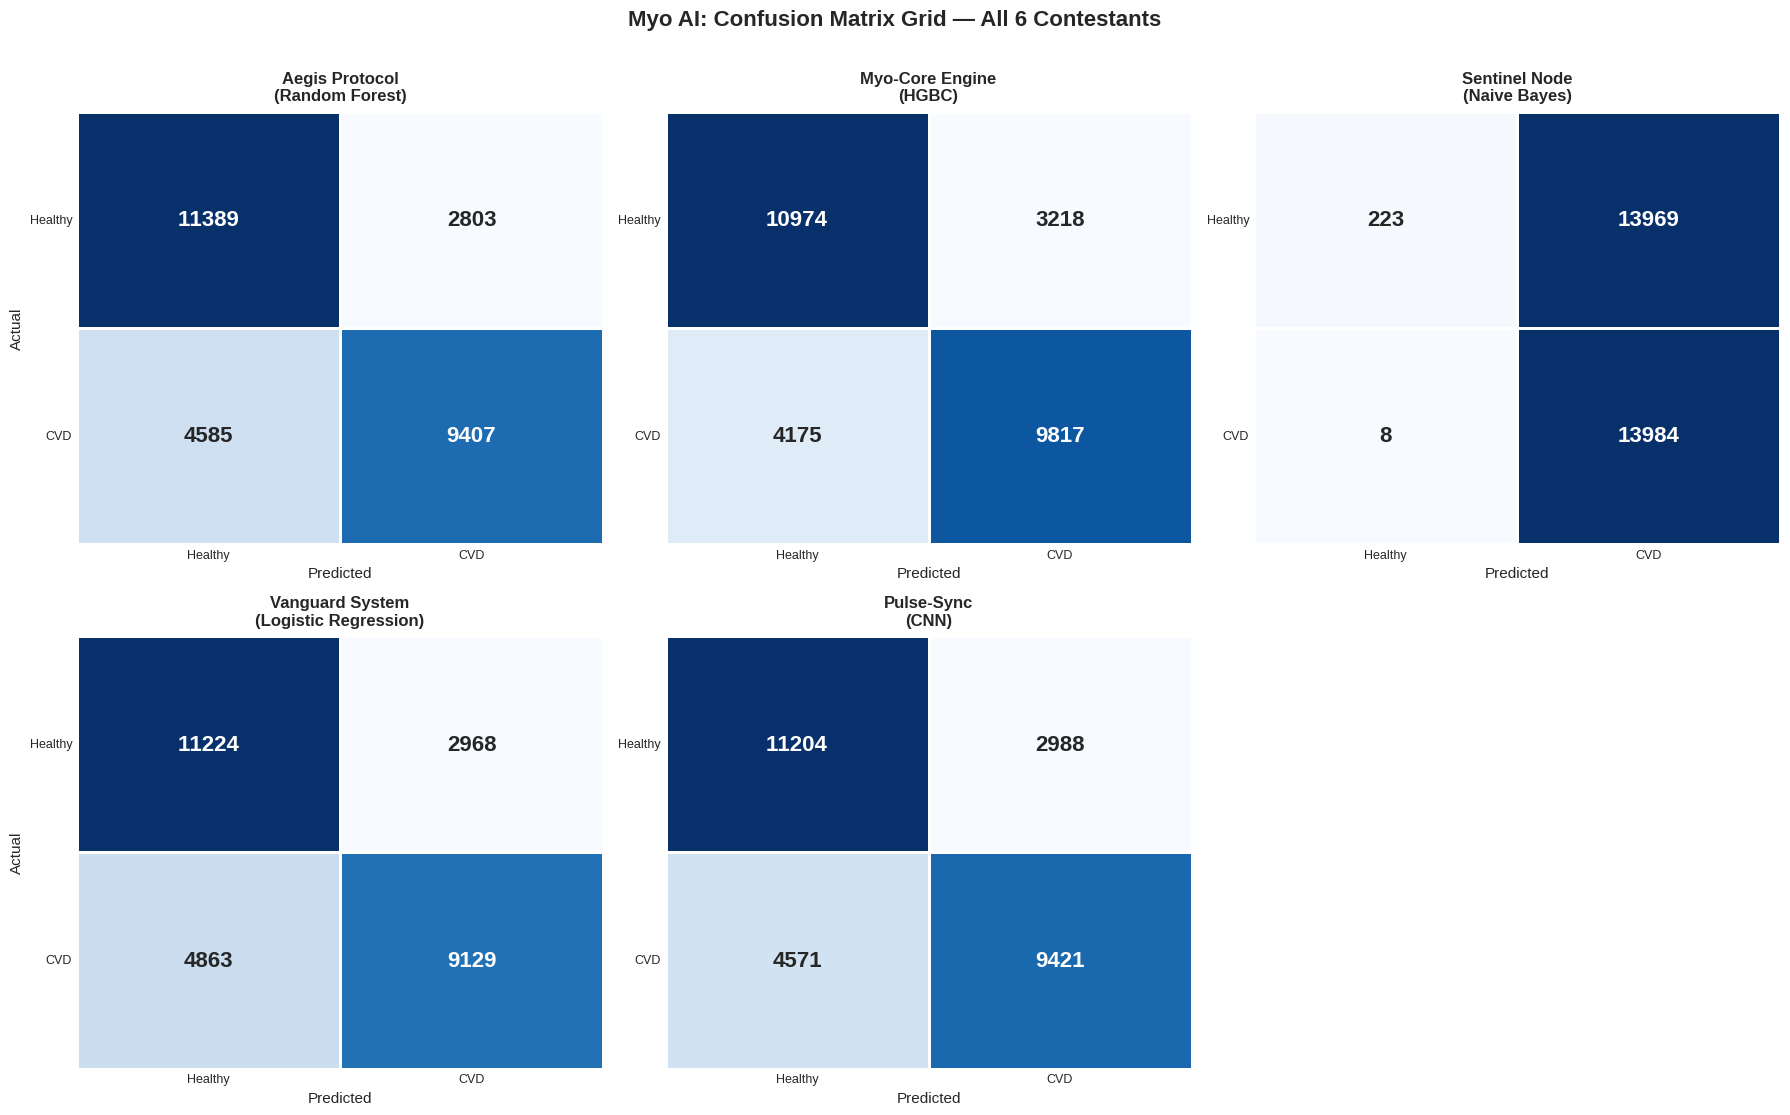

In [19]:
# ══════════════════════════════════════════════════════════════
#  CONFUSION MATRIX GRID — All 6 Models
# ══════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid')

# Include all models for visualization
model_names_to_plot = list(tournament_predictions.keys())

num_models = len(model_names_to_plot)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 11))
axes_flat = axes.flatten()

for idx, name in enumerate(model_names_to_plot):
    y_pred = tournament_predictions[name]
    cm = confusion_matrix(tournament_y_test, y_pred)
    ax = axes_flat[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar=False, linewidths=0.8, linecolor='white',
                annot_kws={'size': 16, 'weight': 'bold'})
    ax.set_title(name, fontsize=12, fontweight='bold', pad=8)
    ax.set_ylabel('Actual' if idx % cols == 0 else '', fontsize=11)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_xticklabels(['Healthy', 'CVD'], fontsize=9)
    ax.set_yticklabels(['Healthy', 'CVD'], fontsize=9, rotation=0)

# Hide any unused subplots (if num_models < rows * cols - this case is fine, all will be used)
for i in range(num_models, len(axes_flat)):
    axes_flat[i].axis('off')
    for text_obj in axes_flat[i].texts:
        text_obj.remove()

fig.suptitle('Myo AI: Confusion Matrix Grid — All 6 Contestants',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 📈 Combined ROC Curve — Tournament Visualization

| Property | Detail |
|---|---|
| **Purpose** | Compare the trade-off between Sensitivity (TPR) and False Alarm Rate (FPR) across all 5 models on a single chart |
| **Key Metric** | `AUC` (Area Under Curve) — higher curves (closer to top-left) indicate better performance |
| **Visual Styling** | Distinct colors and line styles (solid, dashed, dot-dash) to differentiate between the 5 models |
| **Baseline** | Includes a diagonal dashed line representing a "Random Classifier" (AUC = 0.5) for reference |
| **Input** | Uses stored probability predictions (`y_prob`) to calculate the curve at all possible classification thresholds |

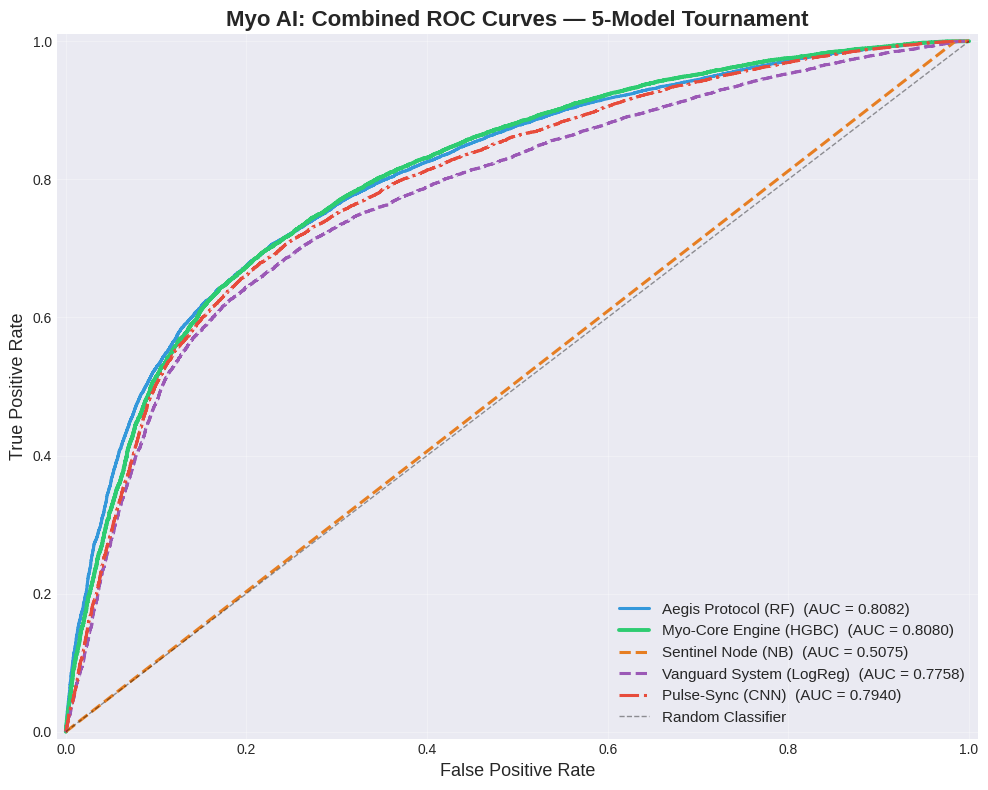

In [20]:
# ══════════════════════════════════════════════════════════════
#  COMBINED ROC CURVE — All 5 Models
# ══════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.style.use('seaborn-v0_8-darkgrid')

roc_styles = [
    ('Aegis Protocol (RF)',       '#3498db', '-',  2.2),
    ('Myo-Core Engine (HGBC)',    '#2ecc71', '-',  2.8),
    ('Sentinel Node (NB)',        '#e67e22', '--', 2.2),
    ('Vanguard System (LogReg)',  '#9b59b6', '--', 2.2),
    ('Pulse-Sync (CNN)',          '#e74c3c', '-.', 2.2),
]

fig, ax = plt.subplots(figsize=(10, 8))

for (name, color, ls, lw) in roc_styles:
    y_prob = tournament_probabilities.get(name)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(tournament_y_test, y_prob)
        auc_val = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, linestyle=ls, linewidth=lw,
                label=f'{name}  (AUC = {auc_val:.4f})')

# Diagonal reference
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('Myo AI: Combined ROC Curves — 5-Model Tournament',
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 🧠 LAYER 3 — THE INTELLIGENCE (Analysis & UI)

> Unsupervised clustering, explainability, and interactive risk simulation. Each cell is documented and contains only one type of output (table, plot, or widget).

| # | Module | Technique | Purpose |
|:---:|---|---|---|
| 1 | **Zenith** | PCA + KMeans | Unsupervised patient risk-group clustering |
| 2 | **Oracle** | SHAP TreeExplainer, Permutation Importance | Global feature-impact explainability |
| 3 | **Myo-Sim** | ipywidgets + Chronos | Interactive risk simulator with 20-year projection |

### 🌌 Zenith Cluster Map — Unsupervised Patient Grouping

| Property | Detail |
|---|---|
| **Purpose** | Unsupervised discovery of patient "Risk Phenotypes" without using the target labels |
| **Input Data** | `myocore_X_test` — Uses the **scaled features** from the Myo-Core engine to ensure valid PCA results |
| **Methodology** | **PCA** (Principal Component Analysis) reduces high-dimensional data to 2D → **K-Means Clustering** groups patients by similarity |
| **Risk Assignment** | Clusters are sorted by their PC1 value to automatically assign "Low", "Moderate", or "High" risk labels |
| **Visualization** | A 2D Scatter Plot showing patient distribution, where colors represent risk groups and "X" markers indicate cluster centroids |

PCA explained variance: 21.96%


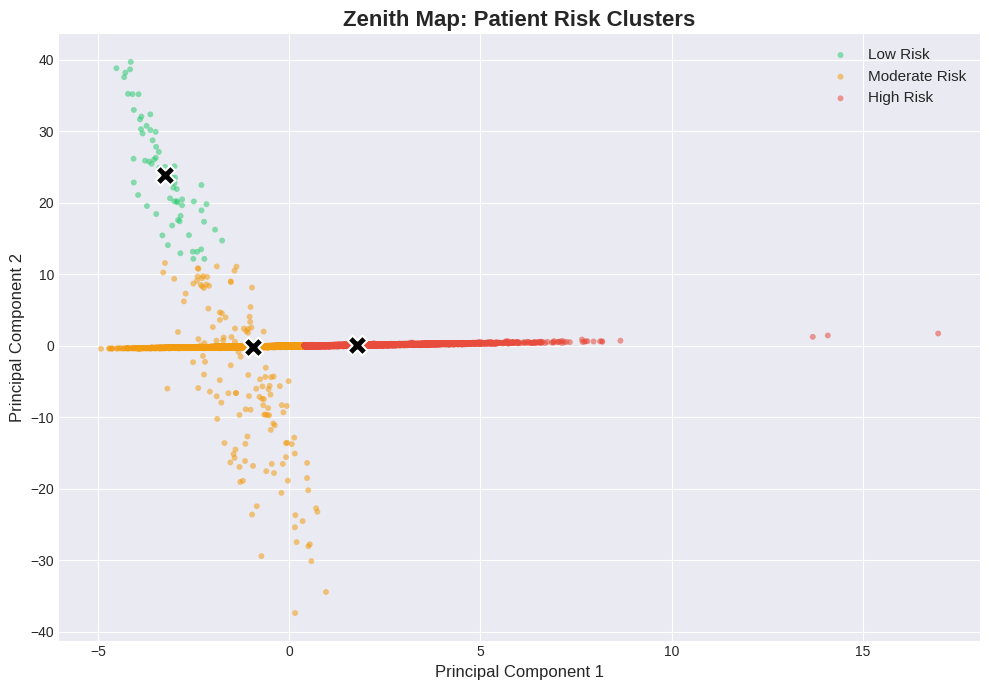

  Low Risk        → 68 patients
  Moderate Risk   → 18,134 patients
  High Risk       → 9,982 patients


In [21]:
# ══════════════════════════════════════════════════════════════
#  ZENITH CLUSTER MAP — Unsupervised Patient Risk Grouping
# ══════════════════════════════════════════════════════════════

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Reduce to 2-D with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(myocore_X_test)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# 2. KMeans clustering (3 patient risk groups)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# 3. Risk-group labelling (order clusters by mean PC1 value)
cluster_order = [X_pca[clusters == c, 0].mean() for c in range(3)]
label_map = {c: rank for rank, c in enumerate(sorted(range(3), key=lambda i: cluster_order[i]))}
cluster_labels = [label_map[c] for c in clusters]

risk_names  = {0: 'Low Risk', 1: 'Moderate Risk', 2: 'High Risk'}
risk_colors = {0: '#2ecc71',  1: '#f39c12',       2: '#e74c3c'}

# 4. Scatter plot
fig, ax = plt.subplots(figsize=(10, 7))
for group_id in range(3):
    mask = [cl == group_id for cl in cluster_labels]
    ax.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=risk_colors[group_id],
        label=risk_names[group_id],
        alpha=0.55, s=18, edgecolors='none',
    )

# Plot cluster centroids
centroids_pca = kmeans.cluster_centers_  # kmeans.cluster_centers_ is already in PCA space
for c in range(3):
    ax.scatter(centroids_pca[c, 0], centroids_pca[c, 1],
               marker='X', s=200, c='black', edgecolors='white', linewidths=1.5)

ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_title('Zenith Map: Patient Risk Clusters', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

# Summary
for g in range(3):
    count = sum(1 for cl in cluster_labels if cl == g)
    print(f"  {risk_names[g]:15s} → {count:,} patients")

### 📉 Permutation Importance — Feature Robustness Check

| Property | Detail |
|---|---|
| **Purpose** | Determine which features are most critical to the Myo-Core model's decision-making |
| **Technique** | **Permutation Importance** — Randomly shuffles one feature at a time and measures the drop in model performance |
| **Metric** | **Mean Accuracy Decrease** — Higher values indicate the feature is more important (the model "breaks" without it) |
| **Robustness** | Calculated over **10 repeats** to generate error bars, showing the stability of the feature's importance |
| **Visualization** | Horizontal Bar Chart displaying the Top 10 features sorted by their impact on prediction accuracy |

Computing Permutation Importance (10 repeats)...


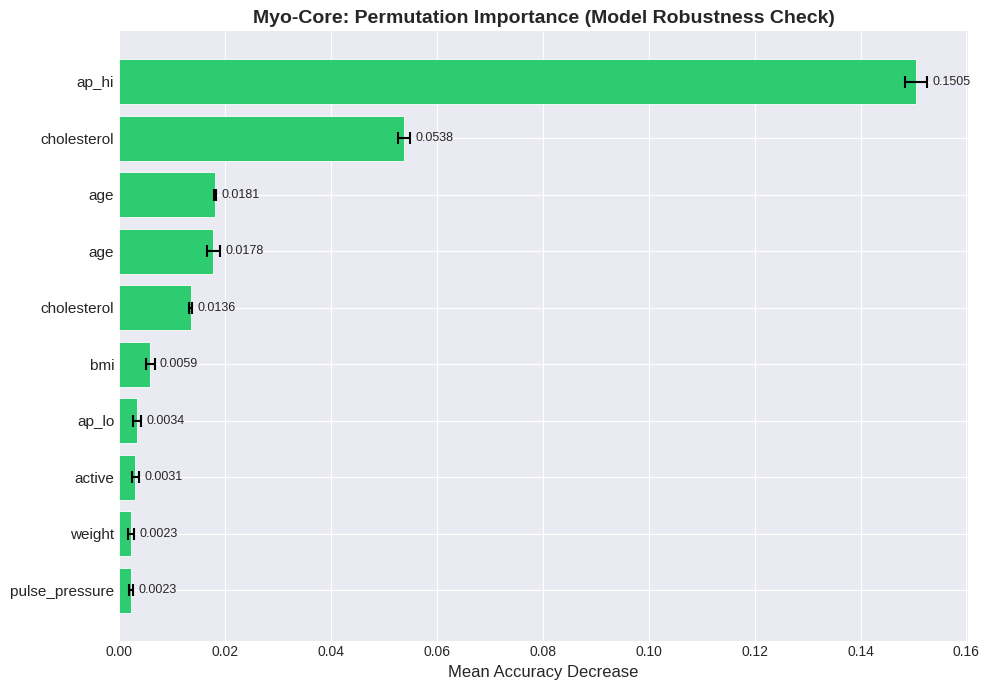

✅ Permutation Importance Complete.


In [22]:
# ══════════════════════════════════════════════════════════════
#  PERMUTATION IMPORTANCE — Myo-Core Model Robustness Check
# ══════════════════════════════════════════════════════════════

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

# Compute permutation importance on the full Myo-Core pipeline
# using the raw (un-preprocessed) test set — the pipeline handles
# imputation + scaling internally before scoring.
print("Computing Permutation Importance (10 repeats)...")
perm_result = permutation_importance(
    myocore_pipeline,
    myocore_X_test_raw,
    myocore_y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy',
)

# Rank and select Top 10
sorted_idx = perm_result.importances_mean.argsort()
top10_idx  = sorted_idx[-10:]

top10_names  = [myocore_X.columns[i] for i in top10_idx]
top10_means  = perm_result.importances_mean[top10_idx]
top10_stds   = perm_result.importances_std[top10_idx]

# Horizontal bar chart with error bars
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(
    range(len(top10_idx)),
    top10_means,
    xerr=top10_stds,
    align='center',
    color='#2ecc71',
    edgecolor='white',
    linewidth=0.6,
    capsize=4,
    error_kw={'elinewidth': 1.5, 'capthick': 1.5, 'color': '#2c3e50'},
)

ax.set_yticks(range(len(top10_idx)))
ax.set_yticklabels(top10_names, fontsize=11)
ax.set_xlabel('Mean Accuracy Decrease', fontsize=12)
ax.set_title('Myo-Core: Permutation Importance (Model Robustness Check)',
             fontsize=14, fontweight='bold')

# Annotate values on bars
for i, (mean, std) in enumerate(zip(top10_means, top10_stds)):
    ax.text(mean + std + 0.001, i, f'{mean:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Permutation Importance Complete.")

### 🔮 Oracle Layer — SHAP Explainability Suite

| Visualization | Purpose | Interpretation |
|---|---|---|
| **1. Beeswarm Plot** | **Global Overview** | Shows the top risk factors across *all* patients. <br>• **Red/Blue Color:** High/Low feature value. <br>• **X-Axis:** Impact on risk (Right = Higher Risk). |
| **2. Force Plot** | **Local "Tug-of-War"** | Visualizes the conflict between risk factors for a *single* patient. <br>• **Red Bars:** Features pushing risk **UP**. <br>• **Blue Bars:** Features pushing risk **DOWN**. |
| **3. Waterfall Plot** | **Decision Logic** | A step-by-step breakdown of how the model reached a specific prediction. <br>• Starts at the **Base Value** (Average Risk) and adds/subtracts values until the final score is reached. |

### 🔮 Oracle Layer — SHAP Beeswarm Plot

| Property | Detail |
|---|---|
| **Purpose** | Explain *how* and *why* the model makes decisions for individual patients (Global Interpretability) |
| **Technique** | **SHAP (SHapley Additive exPlanations)** — A game-theoretic approach to feature attribution |
| **Visualization** | **Beeswarm Plot** — Shows the distribution of SHAP values for each feature |
| **Interpretation** | **Color:** Feature Value (Red = High, Blue = Low) <br> **X-Axis:** Impact on Model Output (Right = Drives Risk Up, Left = Drives Risk Down) |
| **Example** | If "High Blood Pressure" (Red dots) is on the right side, it means high BP increases CVD risk |

Oracle Layer: Computing feature-level SHAP impact...


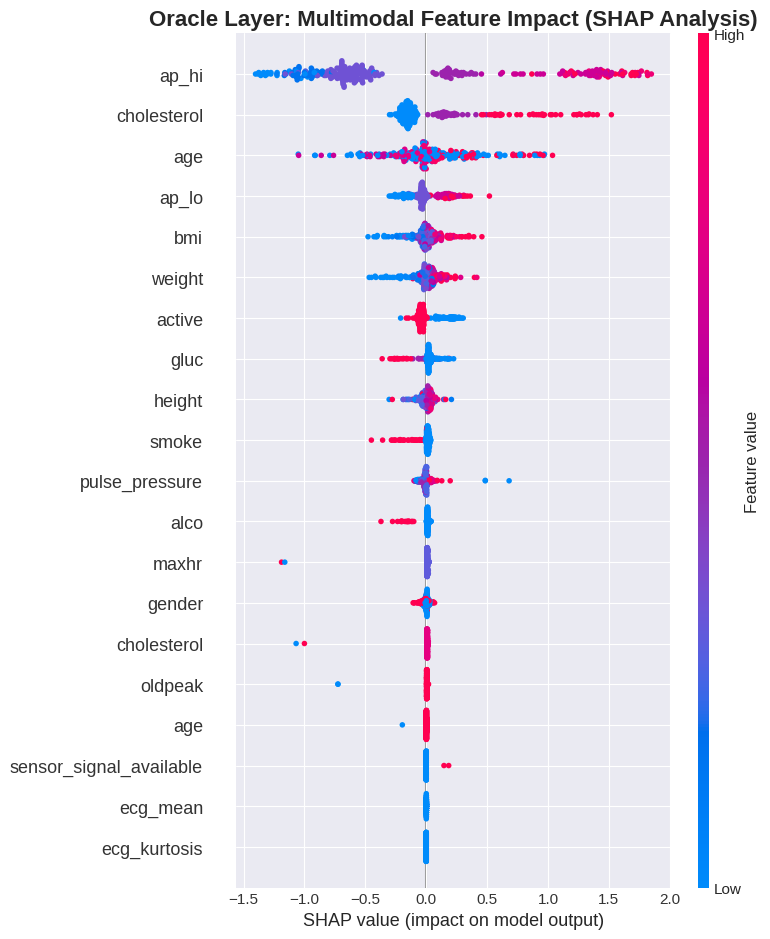

✅ Oracle Layer Beeswarm Complete.


In [23]:
# ══════════════════════════════════════════════════════════════
#  ORACLE LAYER — SHAP Beeswarm Summary Plot (Global View)
# ══════════════════════════════════════════════════════════════

import shap
import matplotlib.pyplot as plt

# 1. Initialize Explainer
explainer = shap.TreeExplainer(myocore_model)
n_explain = min(300, myocore_X_test.shape[0])
X_explain = myocore_X_test[:n_explain]

# 2. Calculate SHAP values
shap_values = explainer.shap_values(X_explain)

print("Oracle Layer: Computing feature-level SHAP impact...")
plt.figure(figsize=(12, 8))

# 3. Draw Beeswarm
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=myocore_feature_names,
    plot_type="dot",
    show=False,
)

plt.title("Oracle Layer: Multimodal Feature Impact (SHAP Analysis)",
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Oracle Layer Beeswarm Complete.")

### ⚔️ Oracle Layer — SHAP Force Plot

| Property | Detail |
|---|---|
| **Purpose** | Visualize the "tug-of-war" between conflicting features for a *single patient's* prediction |
| **Technique** | **Additive Feature Attribution** — Summing positive and negative vectors to reach a final score |
| **Visualization** | **Force Bar** — A horizontal bar chart where length equals impact magnitude |
| **Interpretation** | **Red Bars:** Forces pushing the prediction **HIGHER** (towards disease) <br> **Blue Bars:** Forces pushing the prediction **LOWER** (towards health) |
| **Example** | A patient might have high age (Red push) but low cholesterol (Blue push), balancing out their risk |

🔎 Analyzing High-Risk Patient at Index: 103


<Figure size 2000x400 with 0 Axes>

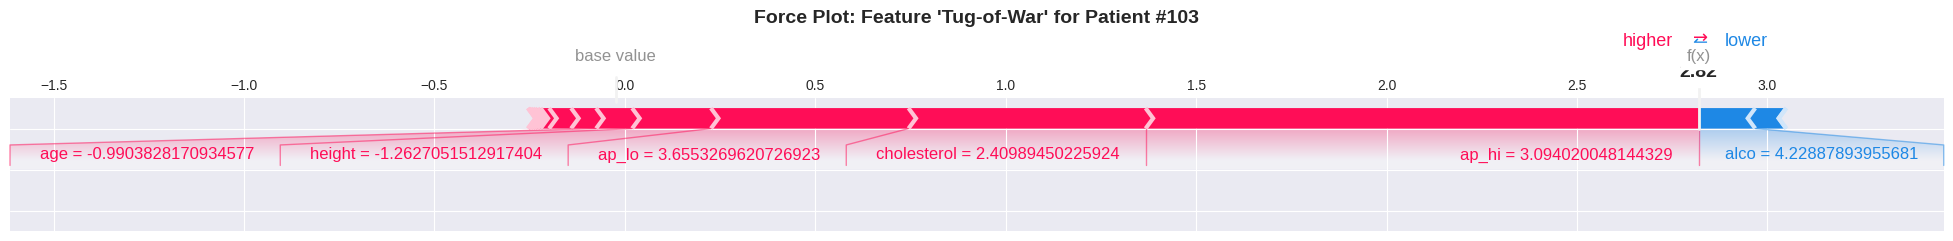

✅ Oracle Layer Force Plot Complete.


In [24]:
# ══════════════════════════════════════════════════════════════
#  ORACLE LAYER — SHAP Force Plot (Single Patient Analysis)
# ══════════════════════════════════════════════════════════════

# 1. Select a high-risk patient (Highest predicted probability in our slice)
# We sum the SHAP values to find the patient where the model pushes "Risk" the hardest
risk_scores = shap_values.sum(axis=1)
patient_idx = risk_scores.argmax()

print(f"🔎 Analyzing High-Risk Patient at Index: {patient_idx}")

# 2. Draw Force Plot
# Note: matplotlib=True allows it to render as a static image in the notebook
plt.figure(figsize=(20, 4))
shap.force_plot(
    explainer.expected_value,
    shap_values[patient_idx],
    X_explain[patient_idx], # Corrected: Changed .iloc to direct indexing
    feature_names=myocore_feature_names,
    matplotlib=True,
    show=False
)

plt.title(f"Force Plot: Feature 'Tug-of-War' for Patient #{patient_idx}",
          fontsize=14, fontweight='bold', y=1.5)
plt.tight_layout()
plt.show()

print("✅ Oracle Layer Force Plot Complete.")

### 🌊 Oracle Layer — SHAP Waterfall Plot

| Property | Detail |
|---|---|
| **Purpose** | A step-by-step audit trail showing how the model moved from the "Average" to the "Specific" |
| **Technique** | **Sequential Breakdown** — Starts at the baseline probability and adds/subtracts each feature's contribution |
| **Visualization** | **Staircase Chart** — Each step represents a feature adding to or subtracting from the total risk |
| **Interpretation** | **$E[f(x)]$ (Base Value):** The average risk for the whole population <br> **$f(x)$ (Final Output):** The specific predicted risk for this patient |
| **Example** | Start at 15% risk → Age adds +5% → Smoking adds +10% → Exercise subtracts -3% → Final Prediction = 22% |

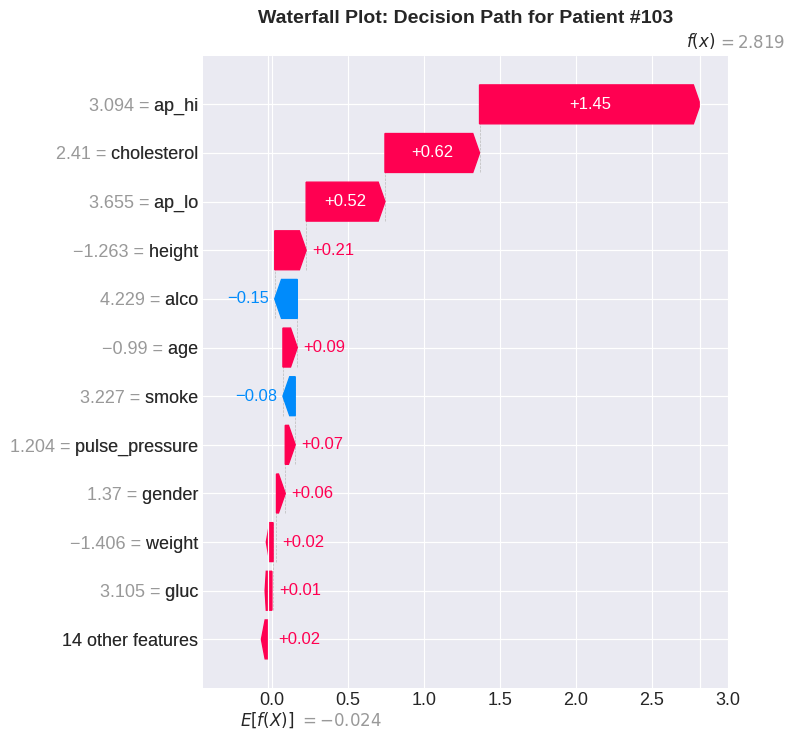

✅ Oracle Layer Waterfall Plot Complete.


In [25]:
# ══════════════════════════════════════════════════════════════
#  ORACLE LAYER — SHAP Waterfall Plot (Step-by-Step Logic)
# ══════════════════════════════════════════════════════════════

# 1. Create a SHAP Explanation Object (Required for Waterfall plots)
# This packages the data, values, and base value together
shap_explanation = shap.Explanation(
    values=shap_values[patient_idx],
    base_values=explainer.expected_value,
    data=X_explain[patient_idx], # Corrected: Changed .iloc to direct indexing
    feature_names=myocore_feature_names
)

# 2. Draw Waterfall Plot
plt.figure(figsize=(8, 8)) # Vertical plots need standard aspect ratio
shap.plots.waterfall(
    shap_explanation,
    max_display=12,
    show=False
)

plt.title(f"Waterfall Plot: Decision Path for Patient #{patient_idx}",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Oracle Layer Waterfall Plot Complete.")

### 📊 Oracle Layer — SHAP Global Importance (Bar Plot)

| Property | Detail |
|---|---|
| **Purpose** | Rank features based on their average absolute impact on the model's predictions |
| **Metric** | **Mean |SHAP| Value** — The average magnitude of the feature's contribution (ignoring direction) |
| **Visualization** | **Bar Chart** — Longer bars indicate features that consistently push the model's prediction (either up or down) the most |
| **Difference** | Unlike the Beeswarm plot (which shows *how* a feature affects risk), this plot simply shows *how much* it matters overall |

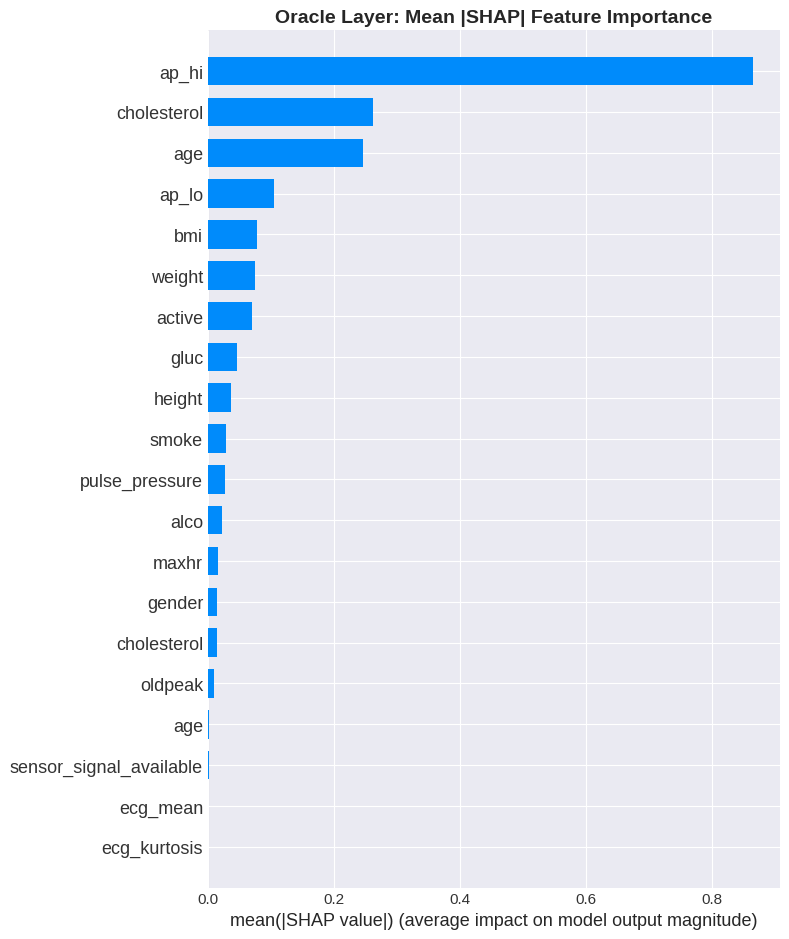

✅ Oracle Layer Bar Plot Complete.


In [26]:
# ══════════════════════════════════════════════════════════════
#  ORACLE LAYER — SHAP Bar Plot (Myo-Core)
# ══════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=myocore_feature_names,
    plot_type="bar",
    show=False,
)
plt.title("Oracle Layer: Mean |SHAP| Feature Importance",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Oracle Layer Bar Plot Complete.")

### 🧬 Myo-Sim Bio-Deck — Chronos Time-Travel Dashboard

| Property | Detail |
|---|---|
| **Purpose** | Interactive digital twin for patient risk simulation and 20-year projection |
| **Input** | User widget controls (age, BP, cholesterol, weight, height, smoker, active, years ahead) |
| **Output** | Gauge chart (current risk), line plot (20-year risk projection), stats panel |
| **Design** | Uses `ipywidgets`, `matplotlib`, and Myo-Core's fitted pipeline for real-time inference |

In [27]:
# ══════════════════════════════════════════════════════════════
#  MYO-SIM BIO-DECK — Interactive "Chronos" Time-Travel Dashboard
# ══════════════════════════════════════════════════════════════

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd


def _predict_risk(age, sys_bp, dia_bp, cholesterol, weight, height,
                  smoker, active, years_future=0):
    """
    Build a single-patient feature vector matching the Myo-Core
    pipeline's training schema, then return P(CVD).
    """
    sim_age = age + years_future
    bmi = weight / ((height / 100) ** 2) if height > 0 else 0
    pulse_pressure = sys_bp - dia_bp

    # Start from zeros matching model feature order
    feature_names = myocore_X.columns.tolist()
    patient = {f: 0.0 for f in feature_names}

    # Map widget inputs → canonical feature names
    mapping = {
        'age': sim_age,
        'ap_hi': sys_bp, 'sys_bp': sys_bp, 'restingbp': sys_bp,
        'ap_lo': dia_bp,
        'cholesterol': cholesterol,
        'weight': weight,
        'height': height,
        'bmi': bmi,
        'pulse_pressure': pulse_pressure,
        'smoke': int(smoker),
        'active': int(active),
        'sensor_signal_available': 0,
    }
    for key, val in mapping.items():
        if key in patient:
            patient[key] = val

    df_patient = pd.DataFrame([patient], columns=feature_names)
    df_imputed = myocore_imputer.transform(df_patient)
    df_scaled  = myocore_scaler.transform(df_imputed)
    prob = myocore_model.predict_proba(df_scaled)[:, 1][0]
    return prob


def _draw_gauge(ax, prob):
    """Render a semicircular gauge chart for CVD risk probability."""
    ax.clear()
    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-0.3, 1.4)
    ax.axis('off')

    # Background arc segments (green → yellow → red)
    n_seg = 100
    for i in range(n_seg):
        frac = i / n_seg
        angle = np.pi * (1 - frac)  # pi → 0
        if frac < 0.4:
            color = '#2ecc71'
        elif frac < 0.7:
            color = '#f39c12'
        else:
            color = '#e74c3c'
        a1 = np.degrees(np.pi - frac * np.pi)
        a2 = np.degrees(np.pi - (frac + 1/n_seg) * np.pi)
        wedge = mpatches.Wedge((0, 0), 1.0, min(a1, a2), max(a1, a2),
                               width=0.25, color=color, alpha=0.35)
        ax.add_patch(wedge)

    # Needle
    needle_angle = np.pi * (1 - prob)
    nx = 0.85 * np.cos(needle_angle)
    ny = 0.85 * np.sin(needle_angle)
    ax.annotate('', xy=(nx, ny), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color='black', lw=2.5))
    ax.plot(0, 0, 'ko', markersize=8)

    # Labels
    status = 'HIGH RISK' if prob > 0.5 else 'LOW RISK'
    status_color = '#e74c3c' if prob > 0.5 else '#2ecc71'
    ax.text(0, -0.15, f'{prob:.1%}', ha='center', va='center',
            fontsize=28, fontweight='bold', color=status_color)
    ax.text(0, 1.25, 'CVD Risk Gauge', ha='center', va='center',
            fontsize=14, fontweight='bold')
    ax.text(-1.1, -0.05, '0%', fontsize=9, ha='center')
    ax.text(1.1, -0.05, '100%', fontsize=9, ha='center')
    ax.text(0, -0.30, status, ha='center', fontsize=13,
            fontweight='bold', color=status_color,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=status_color,
                      alpha=0.15, edgecolor=status_color))


def _draw_chronos_projection(ax, age, sys_bp, dia_bp, cholesterol,
                              weight, height, smoker, active):
    """Plot projected CVD risk over the next 20 years."""
    ax.clear()
    years = list(range(0, 21))
    risks = [
        _predict_risk(age, sys_bp, dia_bp, cholesterol, weight, height,
                      smoker, active, y)
        for y in years
    ]
    ages = [age + y for y in years]

    ax.fill_between(ages, risks, alpha=0.15, color='#e74c3c')
    ax.plot(ages, risks, 'o-', color='#e74c3c', linewidth=2.5,
            markersize=5, label='Projected CVD Risk')
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.6, label='Risk Threshold (50%)')

    ax.set_xlabel('Age (years)', fontsize=12)
    ax.set_ylabel('CVD Probability', fontsize=12)
    ax.set_title('Chronos Engine: 20-Year Risk Projection', fontsize=14, fontweight='bold')
    ax.set_ylim(-0.02, 1.02)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)


# ═══════════════════════════════════════════════════════
#  WIDGET LAYOUT
# ═══════════════════════════════════════════════════════

style = {'description_width': '120px'}
layout = widgets.Layout(width='340px')

w_age         = widgets.IntSlider(value=45, min=18, max=100, step=1,
                                  description='Age:', style=style, layout=layout)
w_sys_bp      = widgets.IntSlider(value=130, min=80, max=220, step=1,
                                  description='Systolic BP:', style=style, layout=layout)
w_dia_bp      = widgets.IntSlider(value=80, min=40, max=130, step=1,
                                  description='Diastolic BP:', style=style, layout=layout)
w_cholesterol = widgets.IntSlider(value=200, min=50, max=600, step=5,
                                  description='Cholesterol:', style=style, layout=layout)
w_weight      = widgets.FloatSlider(value=75, min=30, max=200, step=0.5,
                                    description='Weight (kg):', style=style, layout=layout)
w_height      = widgets.FloatSlider(value=170, min=100, max=220, step=0.5,
                                    description='Height (cm):', style=style, layout=layout)
w_smoker      = widgets.ToggleButton(value=False, description='Smoker',
                                     button_style='', icon='smoking-ban',
                                     layout=widgets.Layout(width='160px'))
w_active      = widgets.ToggleButton(value=True, description='Active',
                                     button_style='success', icon='heartbeat',
                                     layout=widgets.Layout(width='160px'))
w_years       = widgets.IntSlider(value=0, min=0, max=20, step=1,
                                  description='⏳ Years Ahead:', style=style, layout=layout)

output_area = widgets.Output()


def _on_change(*args):
    with output_area:
        clear_output(wait=True)

        age   = w_age.value
        sys_  = w_sys_bp.value
        dia_  = w_dia_bp.value
        chol  = w_cholesterol.value
        wt    = w_weight.value
        ht    = w_height.value
        smoke = w_smoker.value
        act   = w_active.value
        yrs   = w_years.value

        # Current risk (at slider year offset)
        prob = _predict_risk(age, sys_, dia_, chol, wt, ht, smoke, act, yrs)

        # Derived stats
        bmi = wt / ((ht / 100) ** 2) if ht > 0 else 0
        pp  = sys_ - dia_

        # ══ Dashboard figure ════════════════════════════
        fig = plt.figure(figsize=(15, 5.5))
        gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.05, 1.6])

        ax_gauge = fig.add_subplot(gs[0, 0])
        ax_line  = fig.add_subplot(gs[0, 2])

        _draw_gauge(ax_gauge, prob)
        _draw_chronos_projection(ax_line, age, sys_, dia_, chol, wt, ht, smoke, act)

        # Highlight current year marker on projection
        ax_line.axvline(x=age + yrs, color='#3498db', linestyle='-', lw=2, alpha=0.7)
        ax_line.scatter([age + yrs], [prob], color='#3498db', s=120, zorder=5,
                        edgecolors='white', linewidths=2)
        ax_line.annotate(f'Now +{yrs}yr\n{prob:.1%}', xy=(age + yrs, prob),
                         xytext=(10, 15), textcoords='offset points',
                         fontsize=9, fontweight='bold', color='#3498db',
                         arrowprops=dict(arrowstyle='->', color='#3498db'))

        plt.tight_layout()
        plt.show()

        # ══ Stats panel ═════════════════════════════════
        print("─" * 52)
        print(f"  Simulated Age     : {age + yrs}")
        print(f"  BMI               : {bmi:.1f}")
        print(f"  Pulse Pressure    : {pp} mmHg")
        print(f"  CVD Probability   : {prob:.2%}")
        print(f"  Status            : {'██ HIGH RISK' if prob > 0.5 else '██ LOW RISK'}")
        print("─" * 52)


# ══ Wire up all widgets to the callback ════════════════
for w in [w_age, w_sys_bp, w_dia_bp, w_cholesterol, w_weight,
          w_height, w_smoker, w_active, w_years]:
    w.observe(_on_change, names='value')

# ══ Build layout ═════════════════════════════════
title_html = widgets.HTML(
    "<h2 style='text-align:center; color:#FFFFFF;'>"
    " ██ Myo-Sim Bio-Deck — Chronos Time-Travel Interface</h2>"
)

left_col = widgets.VBox([
    widgets.HTML("<b>Patient Vitals</b>"),
    w_age, w_sys_bp, w_dia_bp, w_cholesterol, w_weight, w_height,
    widgets.HTML("<b>Lifestyle</b>"),
    widgets.HBox([w_smoker, w_active]),
    widgets.HTML("<b>⌛ Chronos Engine</b>"),
    w_years,
])

dashboard = widgets.VBox([
    title_html,
    widgets.HBox([
        left_col,
        widgets.VBox([output_area], layout=widgets.Layout(width='70%')),
    ]),
])

# ══ Initial render ════════════════════════
display(dashboard)
_on_change()

print("\n✅ Myo-Sim Bio-Deck with Chronos Engine deployed.")


✅ Myo-Sim Bio-Deck with Chronos Engine deployed.


In [28]:
import pandas as pd

# Load your data (adjust filename and separator if needed)
df = pd.read_csv('cardiac_failure.csv')
df = df.rename(columns={
    'gender': 'sex',
    'ap_hi': 'trestbps',
    'cholesterol': 'chol',
    'cardio': 'target'
})
feature_names = ['age', 'sex', 'trestbps', 'chol', 'smoke', 'weight', 'height']
X = df[feature_names]
y = df['target']

# Check target distribution and data
print("Target value counts:\n", y.value_counts())
print("First few rows of features:\n", X.head())
print("First few target values:\n", y.head())

Target value counts:
 target
0    35021
1    34979
Name: count, dtype: int64
First few rows of features:
         age  sex  trestbps  chol  smoke  weight  height
0  0.588076    2       110     1      0    62.0     168
1  0.730159    1       140     3      0    85.0     156
2  0.624003    1       130     3      0    64.0     165
3  0.528455    2       150     1      0    82.0     169
4  0.516918    1       100     1      0    56.0     156
First few target values:
 0    0
1    1
2    1
3    1
4    0
Name: target, dtype: int64


In [29]:
# Optional: balance the dataset if needed
from sklearn.utils import resample

df_majority = df[df['target'] == y.value_counts().idxmax()]
df_minority = df[df['target'] == y.value_counts().idxmin()]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
X = df_balanced[feature_names]
y = df_balanced['target']
print("Balanced target value counts:\n", y.value_counts())

Balanced target value counts:
 target
0    35021
1    35021
Name: count, dtype: int64


In [31]:
print(y.value_counts())

target
0    35021
1    35021
Name: count, dtype: int64


In [32]:
print(X.head())
print(X.describe())

        age  sex  trestbps  chol  smoke  weight  height
0  0.588076    2       110     1      0    62.0     168
4  0.516918    1       100     1      0    56.0     156
5  0.860705    1       120     2      0    67.0     151
6  0.876113    1       130     3      0    93.0     157
8  0.531940    1       110     1      0    71.0     158
                age           sex      trestbps          chol         smoke  \
count  70042.000000  70042.000000  70042.000000  70042.000000  70042.000000   
mean       0.671604      1.351875    128.799135      1.368493      0.088390   
std        0.191128      0.477558    157.030319      0.681848      0.283863   
min        0.000000      1.000000   -150.000000      1.000000      0.000000   
25%        0.532269      1.000000    120.000000      1.000000      0.000000   
50%        0.689741      1.000000    120.000000      1.000000      0.000000   
75%        0.814944      2.000000    140.000000      2.000000      0.000000   
max        0.999071      2.00000

In [35]:
import pandas as pd

df = pd.read_csv('cardiac_failure.csv')
df = df.rename(columns={
    'gender': 'sex',
    'ap_hi': 'trestbps',
    'cholesterol': 'chol',
    'cardio': 'target'
})
df['sex'] = df['sex'].replace({1: 0, 2: 1})
df = df[(df['trestbps'] > 60) & (df['trestbps'] < 250)]
feature_names = ['age', 'sex', 'trestbps', 'chol', 'smoke', 'weight', 'height']
X = df[feature_names]
y = df['target']

### 💾 Layer 4 — The Archive (Model Export)

| Property | Detail |
| :--- | :--- |
| **Purpose** | Serialize the winning model pipeline for deployment in external applications |
| **Format** | `myocore_pipeline.pkl` (Python Pickle format via Joblib) |
| **Contents** | 1. `SimpleImputer` (Handles missing values) <br> 2. `StandardScaler` (Normalizes data) <br> 3. `HistGradientBoostingClassifier` (The trained model) |
| **Verification** | MD5 Checksum generated to ensure file integrity during transfer |
| **Action** | Triggers automatic browser download of the `.pkl` file |

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
import joblib
import hashlib
from google.colab import files

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', HistGradientBoostingClassifier(random_state=42))
])
pipeline.fit(X, y)

MODEL_FILENAME = 'myocore_pipeline.pkl'
joblib.dump(pipeline, MODEL_FILENAME)

# MD5 checksum for verification
with open(MODEL_FILENAME, 'rb') as f:
    md5 = hashlib.md5(f.read()).hexdigest()
print(f"Model exported as {MODEL_FILENAME} (MD5: {md5})")

# Download in Colab
files.download(MODEL_FILENAME)

Model exported as myocore_pipeline.pkl (MD5: 41b7b686025549a3dfa0b3f4502807af)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>